<div style="text-align: left"> Virro, H., Jemeljanova, M., Chan, W.T., Kmoch, A., Uuemaa, E. </div>
<div style="text-align: left"> Department of Geography, University of Tartu </div>
<div style="text-align: left"> <a href="https://landscape-geoinformatics.ut.ee/">https://landscape-geoinformatics.ut.ee/</a> </div>

<h1><center>Spatial modelling and interpretability with Random Forest</center></h1>
<h3><center>AGILE 2024 CONFERENCE</center></h3>
<h3><center>University of Glasgow, June 6 2024</center></h3>

Machine learning has been increasingly used due to its capabilities to work with large amounts of data, while having minimal assumptions on shape or distribution of variables. However, machine-learning models are often considered a **black-box**, and a lack of interpretability would mean that it is hard to determine if the model has found meaningful and realistic relationships between different phenomena. Thus, **there is a strong need to be able to explain and interpret machine-learning models** to understand the effects and relationships of the underlying modelled processes and used covariates.

Recently, **various methods to interpret the relationships** between the covariates and the target variable in machine learning **have been introduced** (see, e.g, Molnar 2024). **In this workshop, we will present such methods**, namely **partial dependence plots** and **Shapley values**, and provide tips on how to make use of these methods to build less biased, better understandable, and more robust models. This workshop will provide hands-on tasks on interpreting a machine learning model’s results using the Python programming language.

In this workshop, we will use an example of predicting the **total nitrogen** (mg/L) using various environmental variables (topography, soil, land use and land cover, hydrology, agriculture, and climate) from various data sources (see the details in Virro et al. 2022). The total nitrogen data was obtained from the KESE (Estonian Environmental Agency, 2021) environment monitoring system website maintained by the Estonian Environment Agency and was the average value between years 2016 and 2020. This workshop is adapted from the study "Random forest-based modeling of stream nutrients at national level in a data-scarce region" authored by Virro et al. (https://doi.org/10.1016/j.scitotenv.2022.156613).

We will be using Colab in this workshop, however all the materials, including the .yml file needed to create the environment, are available on the GitHub repository: https://github.com/LandscapeGeoinformatics/agile2024_rf_interpretability

### TOC for Jupyter notebook (does not work for Colab):
* [0. Install required packages](#install_package)
* [1. Dependences/ Library Import](#import_library)
* [2. Prepare RF training and test sets](#Data_preparation)
* [3. Hyperparameter tuning](#HPO)
* [4. Model Training (with model parameters based on Hyperparameter tuning)](#HPO_Train)
* [5. Calculate SHAP values](#shap_values)
* [6. Reduce the number of features based on SHAP values](#reduce_model)
* [7. SHAP analysis of the new model](#reduce_model_shap)

# 0. Install required packages <a class="anchor" id="install_package"></a>

First, we will install the required packages.

In [1]:
# Get the requirement file from github repo
!wget -c https://raw.githubusercontent.com/LandscapeGeoinformatics/agile2024_rf_interpretability/main/workshop_materials/requirements.txt
!pip install -r requirements.txt

--2024-06-04 08:04:27--  https://raw.githubusercontent.com/LandscapeGeoinformatics/agile2024_rf_interpretability/main/workshop_materials/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      85  --.-KB/s    in 0s      

2024-06-04 08:04:27 (3.38 MB/s) - ‘requirements.txt’ saved [85/85]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.1 MB/s eta 0:00:00


# 1. Dependences/ Library Import <a class="anchor" id="import_library"></a>
Let's import the packages. For the data processing, we will use **numpy** and **pandas**, to read in geospatial data, **geopandas** will be used. **scikit-learn** will be used for Random Forest modelling, **shap** for shap value calculation and plotting.The partial dependence plots will be generated with scikit-learn's **PartialDependenceDisplay** function. **Seaborn** and **matplotlib** will be used for plotting.

In [2]:
# Import packages
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.inspection import PartialDependenceDisplay

In [3]:
sns.set_theme()

Random Forest relies on randomisation (as the name implies) in subsetting data for decision trees. We set the seed so that each re-run of the Random Forest models results in the same random state and thus, the same outcome.

In [12]:
# Set seed
random_seed = 0
random_state = np.random.seed(random_seed)
random.seed(random_seed)

# 2. Prepare RF training and test sets <a class="anchor" id="Data_preparation"></a>

The geopackage (*gpkg*) with the prediction target (total nitrogen) and feature values (land use, soil etc) is located in a GitHub repository. Let's download it directly from there.

`wget` is a command line function that is used to retrieve data from web servers. We use exclamation mark in front to open a shell and close it immediatelly after the function is executed.

In [4]:
# Getting the gpkg from repo
!wget -c https://github.com/LandscapeGeoinformatics/agile2024_rf_interpretability/raw/main/workshop_materials/agile2024_tn_mean_obs_sites.gpkg

--2024-06-04 08:11:13--  https://github.com/LandscapeGeoinformatics/agile2024_rf_interpretability/raw/main/workshop_materials/agile2024_tn_mean_obs_sites.gpkg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LandscapeGeoinformatics/agile2024_rf_interpretability/main/workshop_materials/agile2024_tn_mean_obs_sites.gpkg [following]
--2024-06-04 08:11:14--  https://raw.githubusercontent.com/LandscapeGeoinformatics/agile2024_rf_interpretability/main/workshop_materials/agile2024_tn_mean_obs_sites.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299008 (292K) [application/octet-stream]
Saving to: 

## 2.1 Data Exploration (very simple one)
Let's explore the contents of the file. We will use the **geopandas** package, since has the capacity to read in and work with spatial data.

In [5]:
# Read observation data
fp = "agile2024_tn_mean_obs_sites.gpkg"
obs_data = gpd.read_file(fp)
display(obs_data)

,site_code,obs_id,obs_value,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,...,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop,geometry
0,SJA8127000,161,1.0288,0.086,0.175,0.092,0.124,1.512569e+08,0.178,0.212,...,0.119,0.176,2.206,14.725,9.732,1.706,0.006,0.005,0.129,POINT (696315.000 6546937.000)
1,SJA9900000,200,1.3402,0.182,0.170,0.178,0.190,8.071414e+08,0.173,0.215,...,0.100,0.191,1.725,15.356,9.827,1.375,0.026,0.008,0.087,POINT (669868.000 6591973.000)
2,SJA3956000,90,6.6156,0.536,0.340,0.520,0.464,4.229881e+08,0.169,0.207,...,0.112,0.150,1.869,15.563,9.910,1.513,0.049,0.003,0.006,POINT (636008.000 6603086.000)
3,SJA1934000,40,1.6676,0.243,0.134,0.172,0.156,2.132077e+08,0.173,0.211,...,0.109,0.183,1.842,14.976,9.745,1.348,0.056,0.004,0.014,POINT (700294.000 6592517.000)
4,SJA7837000,157,2.8696,0.293,0.321,0.330,0.352,3.100426e+08,0.173,0.208,...,0.111,0.151,1.859,15.576,9.724,1.397,0.111,0.007,0.058,POINT (520653.000 6588232.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,SJB3503000,238,8.2250,0.537,0.316,0.523,0.453,1.122941e+08,0.174,0.205,...,0.099,0.111,2.279,15.563,10.033,1.392,0.028,0.002,0.014,POINT (633230.000 6585334.000)
235,SJA3731000,84,1.7250,0.200,0.065,0.122,0.085,6.085978e+07,0.175,0.206,...,0.124,0.223,1.842,14.565,9.663,1.395,0.072,0.003,0.009,POINT (698754.000 6586118.000)
236,SJA0813000,17,3.2500,0.452,0.223,0.499,0.475,4.023375e+07,0.174,0.207,...,0.207,0.272,2.373,16.631,9.019,2.097,0.033,0.007,0.014,POINT (619933.000 6581023.000)
237,SJA8884000,175,3.3000,0.242,0.176,0.232,0.225,1.930663e+09,0.164,0.218,...,0.105,0.145,1.464,15.329,9.728,1.468,0.025,0.010,0.106,POINT (551221.000 6591443.000)


As we can see, the file contains a site code (site_code) and an id (obs_id) for each sampling point, the prediction target as total nitrogen (mg/l)
(obs_value), as well as 82 features, and the geometry, where the spatial information is stored.

In [6]:
obs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   site_code                      239 non-null    object  
 1   obs_id                         239 non-null    int64   
 2   obs_value                      239 non-null    float64 
 3   arable_prop                    239 non-null    float64 
 4   arable_prop_buff_100           239 non-null    float64 
 5   arable_prop_buff_1000          239 non-null    float64 
 6   arable_prop_buff_500           239 non-null    float64 
 7   area                           239 non-null    float64 
 8   awc1_min                       239 non-null    float64 
 9   awc1_max                       239 non-null    float64 
 10  awc1_mean                      239 non-null    float64 
 11  awc1_std                       239 non-null    float64 
 12  bd1_min                     

## 2.2 Data visualization
Let's plot the data spatially, using the observed value of total nitrogen (mg/L).

In [7]:
# Create interactive plot of observation values
obs_data.explore(
    column="obs_value",
    cmap="YlOrRd",
    tooltip=["site_code", "obs_value"],
    marker_kwds={"radius": 4},
    style_kwds={"color": "black", "weight": 1, "fillOpacity": 0.9}
)

## 2.3 Training and Testing Dataset preparation
Now, we will extract the features (that will be used to predict the target) and the prediction target in seperate variables. From the training data, we will remove the id columns the prediction target (first three columns) and the geometry column (the last column), as they are not necessary in the model training. We will seperately save the prediction target values. **Throughout the workshop, we will use X to represent covariates (or features), and Y as the target variable.**

In [8]:
# Extract features and target
X = obs_data.iloc[:, 3:-1]
y = obs_data["obs_value"]

To test the model generalizability, we will split the dataset randomly into 70% of training data and 30% testing data. We will immediatelly create four different dataframes for training and testing to ensure that the features correspond to the respective prediction targets.

In [13]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

We will train our model on 167 samples.

In [14]:
X_train

,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,awc1_mean,awc1_std,bd1_min,...,tri_max,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop
66,0.514,0.281,0.441,0.338,1.063248e+08,0.170,0.206,0.191,0.005,0.419,...,6.367,0.121,0.153,2.028,15.311,9.805,1.595,0.062,0.001,0.000
26,0.106,0.125,0.187,0.188,1.764045e+09,0.145,0.214,0.189,0.005,0.373,...,4.707,0.205,0.233,1.908,16.318,8.630,1.894,0.009,0.006,0.031
76,0.295,0.148,0.300,0.284,3.705538e+07,0.167,0.213,0.193,0.006,0.379,...,4.070,0.306,0.253,2.214,14.906,7.720,1.987,0.024,0.039,0.042
217,0.115,0.062,0.097,0.095,7.369312e+07,0.173,0.202,0.190,0.004,0.409,...,3.800,0.119,0.196,2.285,14.477,9.711,1.647,0.010,0.003,0.117
212,0.001,0.000,0.002,0.001,2.029442e+07,0.175,0.198,0.188,0.004,0.421,...,2.722,0.092,0.159,2.664,14.269,10.261,1.611,0.002,0.003,0.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.494,0.000,0.020,0.000,8.710658e+07,0.170,0.206,0.192,0.006,0.419,...,3.070,0.120,0.148,2.028,15.311,9.791,1.587,0.049,0.001,0.000
192,0.035,0.001,0.006,0.001,3.642620e+07,0.175,0.200,0.187,0.004,0.408,...,3.177,0.134,0.179,1.859,14.493,9.359,1.400,0.340,0.006,0.045
117,0.283,0.226,0.290,0.293,5.315514e+09,0.160,0.220,0.193,0.006,0.371,...,922.779,0.098,0.157,0.157,15.942,9.829,1.346,0.020,0.007,0.083
47,0.298,0.244,0.320,0.319,1.045249e+09,0.000,0.213,0.190,0.006,0.371,...,4.663,0.209,0.224,1.909,16.221,8.650,1.896,0.029,0.017,0.025


In [15]:
y_train

66     7.583333
26     1.008000
76     0.835000
217    2.421500
212    1.362000
         ...   
67     6.609000
192    1.285000
117    1.380000
47     1.855000
172    3.975000
Name: obs_value, Length: 167, dtype: float64

# 3. Hyperparameter tuning <a class="anchor" id="HPO"></a>

Usually, the default parameters provided in the scikit-learn package yield acceptable results. However, depending on the data, a substantially higher performance can be achieved with hyperparameter optimisation and hyperparameter tuning is **very important to avoid overfitting**. It is recommended to start with the automatic methods (e.g., grid search or random search) and then manually check some parameters.

Today, we will use the RandomisedSearchCV (Bergstra and Bengio, 2012) algorithm. We will define a list of possible hyperparameter values (value ranges), and the algorithm will determine which combination of them performs the best.

We will perform 100 runs (`n_iter=100`), and the best hyperparameter combination will be the one with the smallest resulting mean squared error (MSE) when running a model.

We will tune the following parameters:

* `n_estimators` (number of trees in random forest);

* `max_depth` (maximum number of levels in a tree)

In [16]:
# Search for hyperparameters
def search_hyperparams(X, y, random_state):

    # Number of trees in random forest - test between 50 to 200 with testing interval of 10
    n_estimators = list(np.linspace(start=50, stop=200, num=10, dtype=int))

    # Maximum number of levels in a tree - test between 5 and 20 with testing interval of 1
    max_depth = list(np.linspace(start=5, stop=20, num=1, dtype=int))

    # Create dictionary from parameters
    param_distributions = {
        "n_estimators": n_estimators,
        "max_depth": max_depth
    }

    # Perform search for hyperparameters
    estimator = RandomForestRegressor()
    rf_random = RandomizedSearchCV(
        estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
        n_jobs=-1
    )
    rf_random.fit(X, y)

    # Get best parameters
    params = rf_random.best_params_
    params["oob_score"] = True

    return params

In [17]:
%%time

# Perform search for hyperparameters
params = search_hyperparams(X_train, y_train, random_state)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1.06 s, sys: 106 ms, total: 1.16 s
Wall time: 23.8 s


In [18]:
# Show the best hyperparameters
params

{'n_estimators': 183, 'max_depth': 5, 'oob_score': True}

# 4. Model Training (with model parameters based on Hyperparameter tuning) <a class="anchor" id="HPO_Train"></a>

Now that we have the optimal hyperparameters, let's train our model using them. First, we define the algorithm we will use (Random Forest) and set the hyperparameters.

In [19]:
# RF regressor
regressor = RandomForestRegressor()

In [20]:
# Set hyperparameters
regressor = RandomForestRegressor(**params)

Next, we train the model on our covariate and prediction target data.

In [21]:
# Fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=183, oob_score=True)

Let's see how well our model performed on the training data by calculating the R squared value. As R squared values span [0;1], where 1 means an ideal fit between the observations and predicted values, a value of 0.88 indicates a good fit.

In [22]:
# Calculate accuracy on training set
regressor.score(X_train, y_train)

0.9004916094658658

In [23]:
# Predict
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

Let's also determine the model generalisation capacity by determining R squared on independent data that the model has not seen (i.e., our test data). While the score is fair, it is lower than for the training data, meaning that there has been a fair bit of overfitting to the training data.

In [24]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred)

0.6107540928184563

# 5. Calculate SHAP values <a class="anchor" id="shap_values"></a>

SHAP (SHapely Additive exPlanations) is a method that originally comes from cooperative game theory, where it was used to determine each player's contribution on the resulting game score. Similarly, in machine learning, it is used to quantify the contribution of each covariate on the prediction target in an additive, linear manner (meaning that the contributions of features are summed). The SHAP are used to reveal if the contribution is positive or negative, and to quantify it. The values are in the units of the prediction target (in our case, mg/L), which makes them easy to interpret. Read more about SHAP in Molnar 2024 and https://shap.readthedocs.io/en/latest/.

The SHAP value method is model-agnostic, meaning that it can be used on various machine learning algorithms. For our Random Forest models, we will use the TreeSHAP (function **TreeExplainer**), which is a variant of SHAP made specifically for decision tree models.

In [25]:
# Calculate SHAP values
explainer = shap.TreeExplainer(regressor)
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)

Shap values are organised in an array of arrays by sample and then by the covariate.

In [26]:
shap_values

array([[ 2.03676874e+00,  3.64928605e-02,  1.36428930e-02, ...,
         3.99197779e-03,  8.84479982e-02,  1.42690638e-01],
       [-4.27938620e-01, -3.42019408e-02, -1.30053393e-02, ...,
        -8.81272970e-03, -2.75464492e-02, -5.51343133e-03],
       [-1.71110855e-01, -2.82034073e-02, -9.97642918e-03, ...,
        -2.62655340e-03, -6.96200768e-02, -9.18585316e-03],
       ...,
       [-1.33525746e-01, -1.84244100e-03, -1.11513048e-02, ...,
         7.74651576e-03, -2.40394021e-02, -1.21169003e-02],
       [-1.58007527e-01,  4.51673974e-02, -8.40501395e-03, ...,
        -9.57372466e-04, -7.53339466e-02, -1.18886328e-03],
       [ 1.28927935e-01,  3.70673976e-02,  1.35868764e-02, ...,
        -3.83942419e-03, -1.33394690e-02, -6.65885880e-03]])

The SHAP values can be calculated both globally (for the whole dataset) and locally (distinguishing individual instances). First, let's plot SHAP globally using the summary plot.

This plot shows the **absolute contribution of each feature**. The features are ordered based on their importance, and here, 20 out of 82 most important features are plotted. On average, the highest contribution to the total nitrogen value is by the proportion of arable land in catchment (arable_prop), features mean rock content of the first layer (rock1_mean), silt % of the first soil layer (silt1_mean) and rip_veg_nat_prop (total area of riparian vegetation buffer around natural streams divided by catchment area), all exceeding 0.1 mg/L. All other features contributed by 0.1 mg/L or less.

**NB!** While SHAP might seem similar to permutation based feature importance, the latter describes feature contribution to the prediction accuracy, not to the target value! Please be mindful when interpreting the results.

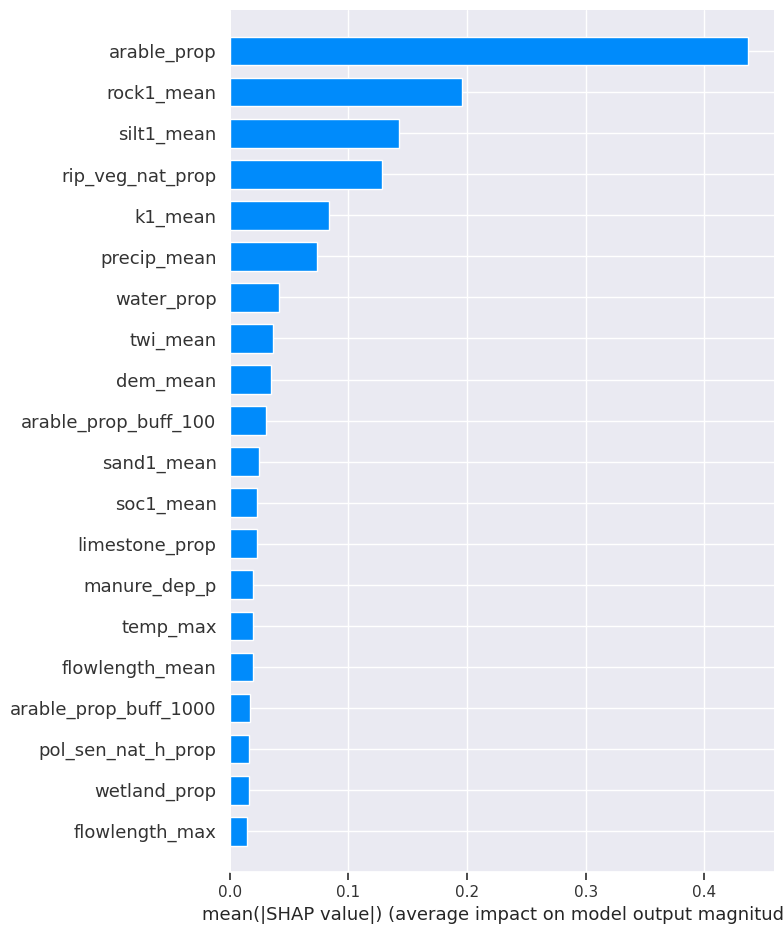

<Figure size 640x480 with 0 Axes>

In [28]:
# SHAP summary bar plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")
plt.tight_layout()

For a more thorough exploration, it is always advisable to plot the **summary beeswarm plot**, where individual instances can be observed. The interpretation of the summary beeswarm plot is as follows: each point is the SHAP value in a distinct sampling location. For each feature, there are as many points as sampling locations in our dataset. The color describes the covariate value relative to the range of covariate values in the dataset, for each covariate seperately. The red dots represent high values (for example, high rock content in the first layer), while blue represents low values.

The impact on the target value (in our case, total nitrogen mg/L) can be read from the x axis: the more a certain point is positioned to the right, the higher the contribution, and vice versa; for example, high arable proportion in the catchment (arable_prop) results in up to 0.6 mg/L higher total nitrogen concentration in certain locations.

Besides that, we can see that features like rock content in the first layer (rock1_mean) and the arable proportion in the catchment (arable_prop) contribute positively to the target, since higher feature values result in higher contribution, while features like k1_mean (mean hydraulic conductivity of the first layer) and rip_veg_nat_prop (total area of riparian vegetation buffer around natural streams divided by catchment area) have a negative influence: lower values result in higher total nitrogen concentration.

As you can see, the contribution of high vs. low values of feature is not symmetric. For example, low values of rip_veg_nat_prop contribute up to 2.6 mg/L increase on the target, while high values of the same feature decrease the total nitrogen content by only 0.6 mg/L at most.

**SHAP values and partial dependence plots (below) are a great tool of model validation: the modeler can see if the relationships revealed by the model are logical and correspond to the domain knowledge.**

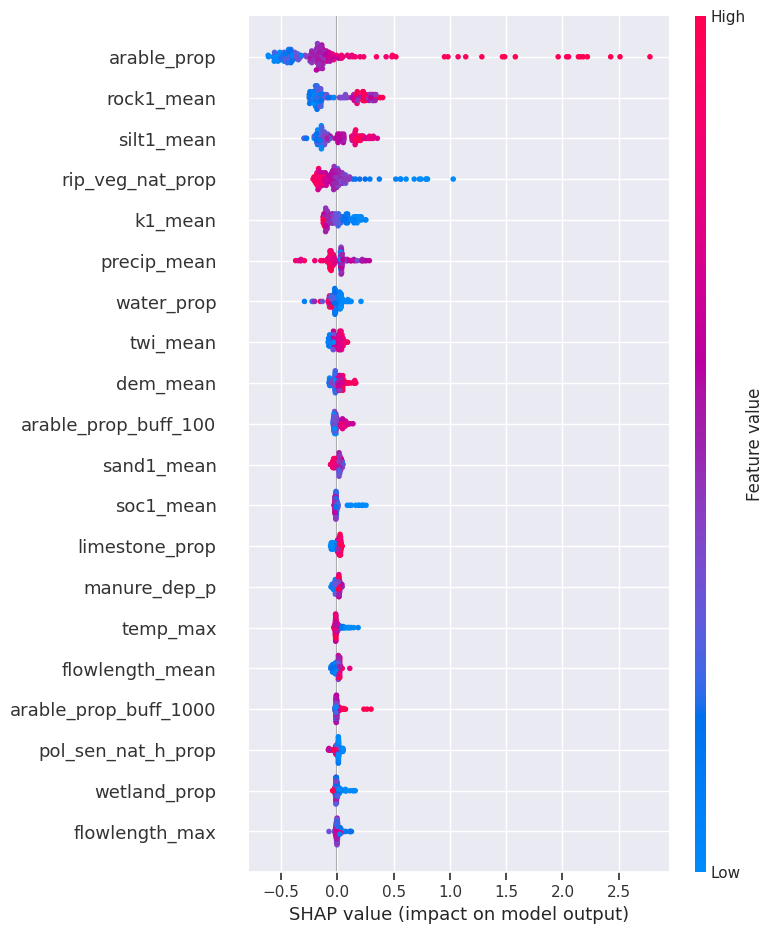

<Figure size 640x480 with 0 Axes>

In [29]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns)
plt.tight_layout()

To understand better how each predictor is contributing to the model and how it is related to the target variable, we can use partial dependence plots. We don't want to plot all 82 features and therefore we will subset the 10 most important covariates based on SHAP values.

## 5.1 Top 10 features with the highest SHAP value

In [30]:
#extracting top 10 features based on SHAP values
feature_names = X_train.columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=["col_name","feature_importance_vals"])
shap_importance.sort_values(by=["feature_importance_vals"],
                               ascending=False, inplace=True)
shap_importance[:10]

,col_name,feature_importance_vals
0,arable_prop,0.436909
48,rock1_mean,0.196038
56,silt1_mean,0.142884
45,rip_veg_nat_prop,0.127985
32,k1_mean,0.084089
43,precip_mean,0.073234
80,water_prop,0.041908
77,twi_mean,0.036739
19,dem_mean,0.034397
1,arable_prop_buff_100,0.030823


## 5.2 Plot the partial dependence

Partial Dependence plots show the marginal effect of feature on a target in a ML model, that is, the contribution of a specific feature on the target after the average impacts of other features have been removed. Usually, partial dependence plots are drawn for one to two features at time, as the interpretation of more features becomes increasingly complex.

With these plots, one can determine if the influence of feature on the prediction target is linear or non-linear. Moreover, the x axis shows the values of the respective feature, while the y axis visualises the target values (in our case, total nitrogen, mg/L). Thus, these plots are intuitive to understand and interpret and certain thresholds of influence can be determined. For example, with an increasing proportion of arable land (feature "arable_prop"), the concentration of total nitrogen increases. A steep increase is noted when the arable proportion exceeds 40%, raising from around 2.5 mg/L to around 4.5 mg/L. As with SHAP, these plots are a great validation tool. New insights can also be gained, however caution should be exercised when interpreting the relationships. For example, keep in mind that the marks of data indicate value density around certain values in your dataset, therefore a lower certainty is in the data range with low number of points (e.g., range 20-40 vs. range 60-80 for the feature k1_mean).

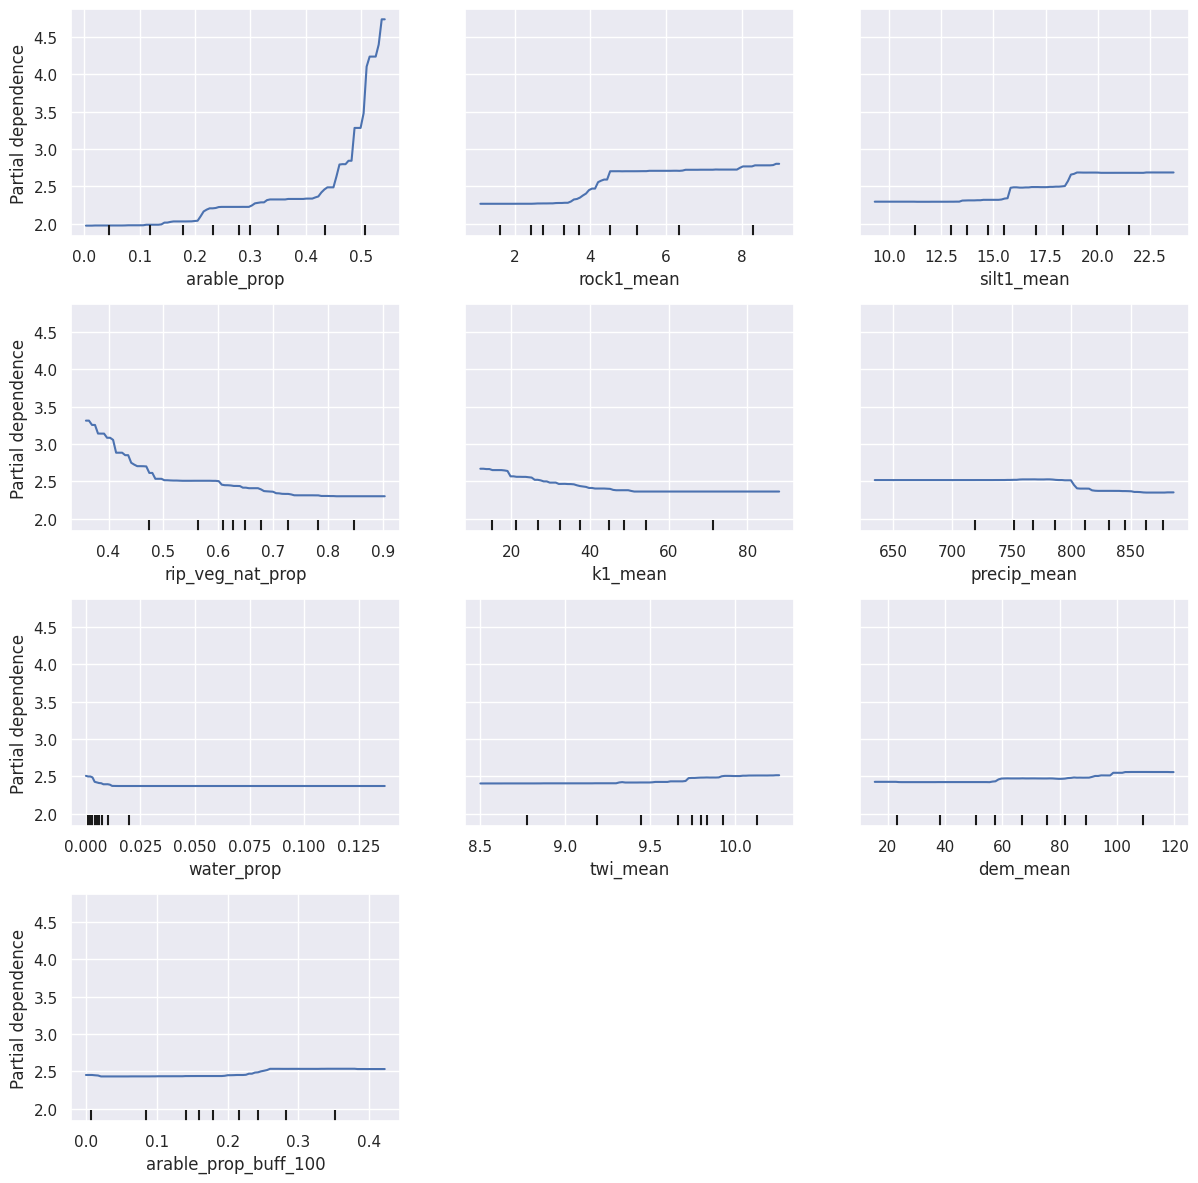

In [46]:
# Create partial dependence plot (Full Model)
fig, ax = plt.subplots(figsize=(12, 12))
disp = PartialDependenceDisplay.from_estimator(regressor, X_train, shap_importance[:10]["col_name"].values, ax=ax)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()

# 6. Reduce the number of features based on SHAP values <a class="anchor" id="reduce_model"></a>

As a general rule, we are interested in models needing as little features as possible due to computational etc. limitations. There are various feature reduction methods, such as permutation based feature importance, forward feature selection, and others. Now we will decrease our feature set using the results of SHAP and will explore the difference in the prediction accuracy.

We will use the 10 most influential features (from the original 82) as determined by SHAP and will re-train the Random Forest model with this decreased feature set.

In [32]:
# Create DataFrame of absolute mean SHAP values
abs_mean_shap_df = pd.DataFrame(
    list(zip(X_test.columns, np.abs(shap_values).mean(0))), columns=["feature", "abs_mean_shap"]
)

In [33]:
# Sort based on absolute mean SHAP values
abs_mean_shap_df = abs_mean_shap_df.sort_values(by=["abs_mean_shap"], ascending=False).reset_index(drop=True)

In [34]:
abs_mean_shap_df

,feature,abs_mean_shap
0,arable_prop,0.436909
1,rock1_mean,0.196038
2,silt1_mean,0.142884
3,rip_veg_nat_prop,0.127985
4,k1_mean,0.084089
...,...,...
77,k1_max,0.000066
78,sand1_min,0.000030
79,clay1_max,0.000000
80,rock1_min,0.000000


In [35]:
# List of most important features
n_features = 10
top_features = abs_mean_shap_df["feature"].head(n_features).to_list()
print(top_features)

['arable_prop', 'rock1_mean', 'silt1_mean', 'rip_veg_nat_prop', 'k1_mean', 'precip_mean', 'water_prop', 'twi_mean', 'dem_mean', 'arable_prop_buff_100']


We subset the relevant features from the original training dataset.

In [36]:
# Generate new training and test feature sets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

## 6.1 Train model on reduced data

Again, we will determine the optimal hyperparameters with the exact same methodology as before, but on the reduced training set.

In [37]:
%%time

# Perform search for hyperparameters
params_reduced = search_hyperparams(X_train, y_train, random_state)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1.09 s, sys: 93 ms, total: 1.18 s
Wall time: 22.2 s


Let's train the model with the optimal hyperparameters and the reduced training set the same way we did before.

In [38]:
# RF regressor
regressor_reduced = RandomForestRegressor()

# Set hyperparameters
regressor_reduced.set_params(**params_reduced)

# Fit model
regressor_reduced.fit(X_train_reduced, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, oob_score=True)

As you can see, the accuracy on the training and test set with the lower feature set has remained practically the same with less data needed. Great! Keep in mind though, that this is not a guarantee- the scores can decrease, depending on the data, etc.

In [39]:
# Calculate accuracy on training set
regressor_reduced.score(X_train_reduced, y_train)

0.9041982174308413

In [40]:
# Predict
Y_train_pred_reduced = regressor_reduced.predict(X_train_reduced)
Y_test_pred_reduced = regressor_reduced.predict(X_test_reduced)

In [42]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred_reduced)

0.6119831048562522

# 7. SHAP analysis of the new model <a class="anchor" id="reduce_model_shap"></a>

Now, we will again plot the SHAP values and explore the differences in contribution between the full and the decrease data sets.

In [43]:
# Calculate SHAP values
explainer_reduced = shap.TreeExplainer(regressor_reduced)
shap_values_reduced = shap.TreeExplainer(regressor_reduced).shap_values(X_train_reduced)

The order has remained the same but the influence has increased a bit. That is a good indicator, showing that the model is quite robust and you have meaningful predictors.

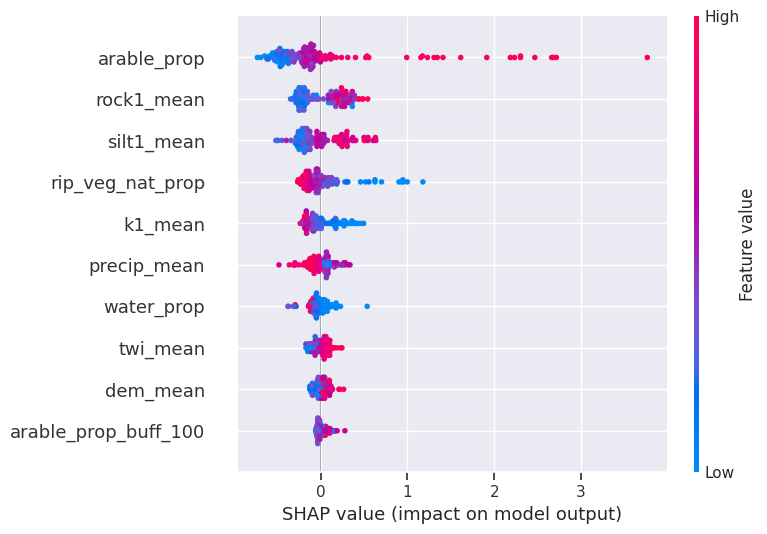

<Figure size 640x480 with 0 Axes>

In [44]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values_reduced, features=X_train_reduced, feature_names=X_train_reduced.columns)
plt.tight_layout()

Let's look at the partial dependence plots once again. As before, the relationships remain the same. As with SHAP, these plots are a great validation tool. New insights can also be gained, however caution should be exercised when interpreting the relationships.

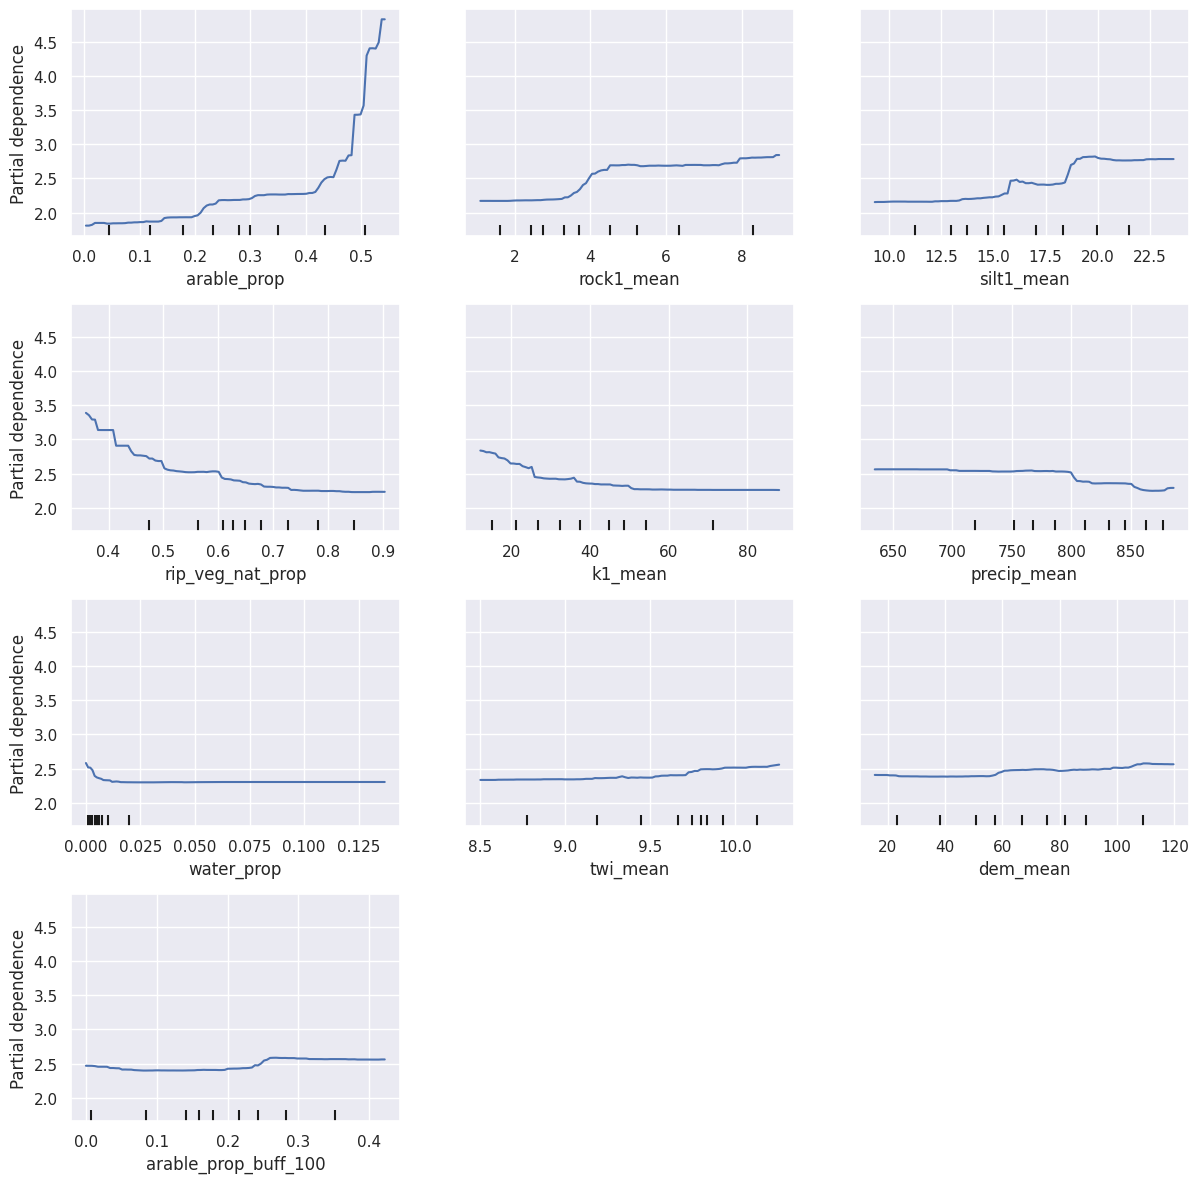

In [45]:
# Create partial dependence plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = PartialDependenceDisplay.from_estimator(regressor_reduced, X_train_reduced, X_train_reduced.columns, ax=ax)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()

## 7.1 Plot the predictions spatially

Now, we will plot all predictions spatially (for both train and test locations) of our target value (total nitrogen, mg/L) from our model with the reduced feature set. First, we will create a dataframe with all locations.

In [52]:
# Concatenate reduced features and sort by index
X_reduced = pd.concat([X_train_reduced, X_test_reduced]).sort_index()
X_reduced.head()

,arable_prop,rock1_mean,silt1_mean,rip_veg_nat_prop,k1_mean,precip_mean,water_prop,twi_mean,dem_mean,arable_prop_buff_100
0,0.086,0.117,12.941,0.640,57.067,785.0654,0.005,9.732,45.200,0.175
1,0.182,4.713,18.374,0.606,41.811,748.0954,0.008,9.827,57.153,0.170
2,0.536,8.828,19.020,0.402,26.810,759.1812,0.003,9.910,84.989,0.340
3,0.243,4.079,14.901,0.679,52.092,816.1184,0.004,9.745,53.850,0.134
4,0.293,6.022,16.916,0.580,40.121,765.9824,0.007,9.724,36.902,0.321


Next, we will use our trained model to predict the target values for all locations.

In [57]:
# Predict with the reduced model
predictions = regressor_reduced.predict(X_reduced)
display(predictions)

array([1.5588892 , 1.81156043, 6.13479005, 1.97895938, 2.4551719 ,
       1.6445755 , 2.72801254, 2.82186171, 1.60125835, 2.40906186,
       1.45398173, 1.50434473, 2.0377047 , 3.21304206, 2.86382147,
       2.51397836, 1.23237085, 6.3193568 , 1.3483554 , 2.14852013,
       2.78902869, 6.96826837, 1.7403779 , 2.00789244, 1.44734044,
       1.22870823, 1.19671033, 1.29402572, 1.30879478, 1.42478301,
       2.09416087, 1.76187778, 2.34808015, 2.16257265, 4.73671398,
       2.943054  , 2.85207934, 6.78351208, 3.65258273, 1.61414633,
       9.89353955, 4.1752065 , 3.60485639, 4.31830622, 2.40784954,
       1.44736543, 3.77432428, 1.65259488, 1.27071544, 1.37957689,
       1.4026815 , 2.44730843, 2.14566132, 1.93213126, 1.40276683,
       2.24978905, 1.95028441, 2.73505939, 3.31238927, 3.65390224,
       2.87231483, 2.86315808, 2.13296973, 1.84296616, 7.75768699,
       7.97447105, 7.65991847, 5.80115386, 1.19045659, 1.52000163,
       2.23547782, 1.66197916, 1.14040632, 1.22120538, 2.59713

In [58]:
# Add predictions to observation data
obs_data_pred = obs_data.copy()
obs_data_pred["pred_value"] = predictions
obs_data_pred.head()

,site_code,obs_id,obs_value,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,...,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop,geometry,pred_value
0,SJA8127000,161,1.0288,0.086,0.175,0.092,0.124,151256900.0,0.178,0.212,...,0.176,2.206,14.725,9.732,1.706,0.006,0.005,0.129,POINT (696315.000 6546937.000),1.558889
1,SJA9900000,200,1.3402,0.182,0.170,0.178,0.190,807141375.0,0.173,0.215,...,0.191,1.725,15.356,9.827,1.375,0.026,0.008,0.087,POINT (669868.000 6591973.000),1.811560
2,SJA3956000,90,6.6156,0.536,0.340,0.520,0.464,422988125.0,0.169,0.207,...,0.150,1.869,15.563,9.910,1.513,0.049,0.003,0.006,POINT (636008.000 6603086.000),6.134790
3,SJA1934000,40,1.6676,0.243,0.134,0.172,0.156,213207725.0,0.173,0.211,...,0.183,1.842,14.976,9.745,1.348,0.056,0.004,0.014,POINT (700294.000 6592517.000),1.978959
4,SJA7837000,157,2.8696,0.293,0.321,0.330,0.352,310042550.0,0.173,0.208,...,0.151,1.859,15.576,9.724,1.397,0.111,0.007,0.058,POINT (520653.000 6588232.000),2.455172


Now, we will plot our predicted values.

In [59]:
# Create interactive plot of predicted values
obs_data_pred.explore(
    column="pred_value",
    cmap="YlOrRd",
    tooltip=["site_code", "obs_value", "pred_value"],
    marker_kwds={"radius": 4},
    style_kwds={"color": "black", "weight": 1, "fillOpacity": 0.9}
)

**Residuals** are the difference between the observed and predicted values. If residuals are spatially autocorrelated (meaning that values in close vicinity are similar), it indicates that there might be a feature missing. This information can be used to further improve the model.

In [60]:
# Calculate residuals between observed and predicted values
obs_data_pred["residual"] = obs_data_pred["obs_value"] - obs_data_pred["pred_value"]

In [61]:
# Create interactive plot of residuals
obs_data_pred.explore(
    column="residual",
    cmap="RdBu",
    tooltip=["site_code", "obs_value", "pred_value", "residual"],
    marker_kwds={"radius": 4},
    style_kwds={"color": "black", "weight": 1, "fillOpacity": 0.9}
)

Next, let's explore the observed and predicted values. The plot indicates that the model overestimated the some of the low values and underestimated some of the high values, which is characteristic of Random Forest models. It could be due to the characteristics of how data is subsampled for the decision trees, meaning that the extreme values are not always included in training each tree, therefore the model does not learn all the possible value combinations.

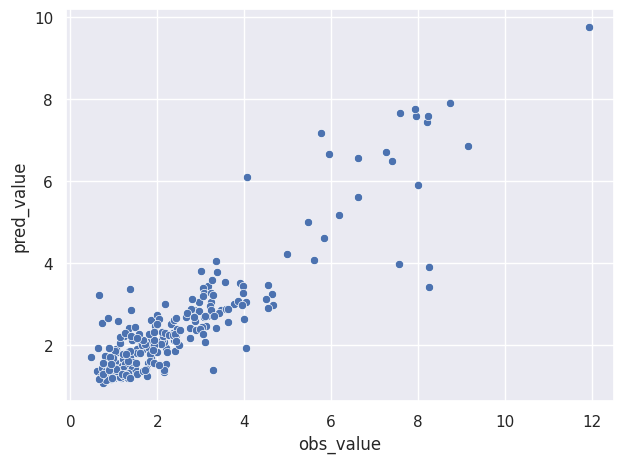

In [ ]:
# Plot observed and predicted values
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=obs_data_pred, x="obs_value", y="pred_value")
plt.tight_layout()